任务：房价预测

流程：

1. 数据读取与清洗
2. 特征工程（提取特征与细化）
3. 模型训练
4. 模型评估

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy.stats import norm, skew
from scipy import stats

%matplotlib inline

数据读取

In [87]:
train = pd.read_csv("/data/ys_data/housePrice/train.csv")
test = pd.read_csv("/data/ys_data/housePrice/test.csv")

In [88]:
# 保留并删除原有Id列
# 保留id列
train_ID = train['Id']
test_ID = test['Id']

# 删除id列
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

数据预处理和特征工程

* 异常值处理
* 目标变量分析
* 缺失值处理
* 特征相关性
* 进一步挖掘特征
* 对数值型特征进行Box-Cox变换
* 独热编码

Text(0, 0.5, 'SalePrice')

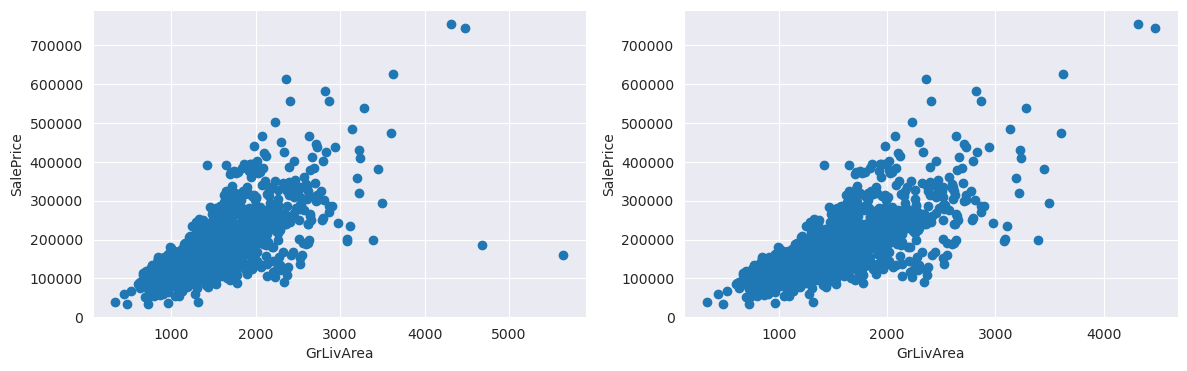

In [89]:
# 异常值处理
# 规定图像大小
plt.figure(figsize=(14, 4))

# 规定图像出现位置 - 第一张图像
plt.subplot(121)
# 绘制散点
plt.scatter(x=train['GrLivArea'], y=train['SalePrice'])
# 规定xy坐标
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

# 第二张图像 - 处理离群点（）
train = train.drop(train[((train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000))].index)
plt.subplot(122)
plt.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

/tmp/ipykernel_2787100/4220877442.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'], fit=norm, ax=ax[0])


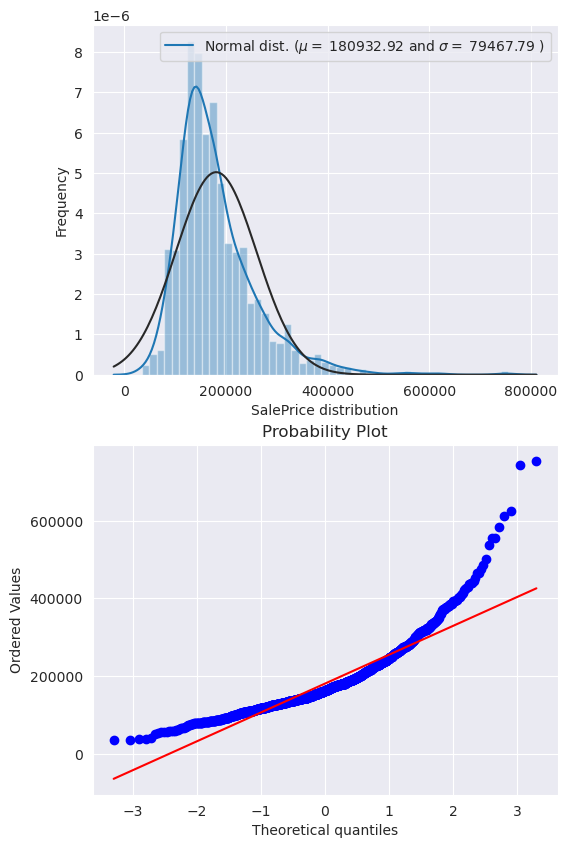

In [90]:
# 目标变量分析 - SalePrice
# 分布图
fig, ax = plt.subplots(nrows=2, figsize=(6, 10))
sns.distplot(train['SalePrice'], fit=norm, ax=ax[0])
(mu, sigma) = norm.fit(train['SalePrice'])
ax[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('SalePrice distribution')

# QQ图
stats.probplot(train['SalePrice'], plot=ax[1])
plt.show()

/tmp/ipykernel_2787100/4280912275.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'], fit=norm, ax=ax[0])


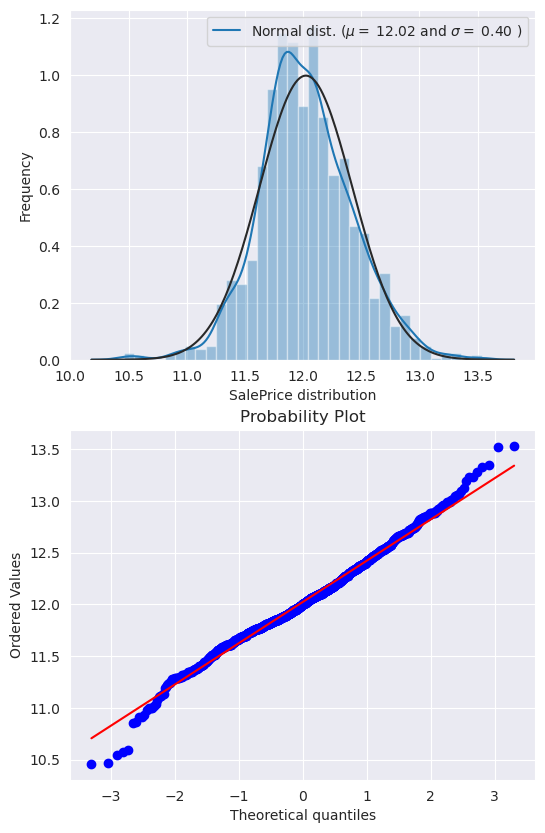

In [91]:
# 由于分布呈正偏态，对其做对数变换让数据接近正态分布
# 用numpy中的log1p将log(1+x)应用于所有元素
train['SalePrice'] = np.log1p(train['SalePrice'])

# 查看转换后数据分布
# 分布图
fig, ax = plt.subplots(nrows=2, figsize=(6, 10))
sns.distplot(train['SalePrice'], fit=norm, ax=ax[0])
(mu, sigma) = norm.fit(train['SalePrice'])
ax[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('SalePrice distribution')

# QQ图
stats.probplot(train['SalePrice'], plot=ax[1])
plt.show()

数据合并以及查看

In [92]:
# 合并数据集查看整体数据集信息，忽略缺失值
full = train._append(test, ignore_index=True)
full.drop(['SalePrice'], axis=1, inplace=True)

In [93]:
# 查看数据集整体情况，查看数据集缺失情况同时便于规划数据清洗
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   int64  
 1   MSZoning       2913 non-null   object 
 2   LotFrontage    2431 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2917 non-null   object 
 7   LandContour    2917 non-null   object 
 8   Utilities      2915 non-null   object 
 9   LotConfig      2917 non-null   object 
 10  LandSlope      2917 non-null   object 
 11  Neighborhood   2917 non-null   object 
 12  Condition1     2917 non-null   object 
 13  Condition2     2917 non-null   object 
 14  BldgType       2917 non-null   object 
 15  HouseStyle     2917 non-null   object 
 16  OverallQual    2917 non-null   int64  
 17  OverallCond    2917 non-null   int64  
 18  YearBuil

In [94]:
full.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2917.000000,2431.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2894.000000,2916.000000,2916.000000,...,2916.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,57.135756,69.180584,10139.439150,6.086390,5.564964,1971.287967,1984.248200,101.733587,439.015432,49.616255,...,472.409465,93.629414,47.280082,23.114158,2.604045,16.073363,2.088790,50.860816,6.213576,2007.792938
std,42.532140,22.791719,7807.036512,1.406704,1.113414,30.286991,20.892257,178.510291,444.182329,169.258662,...,214.620878,126.532643,67.118965,64.263424,25.196714,56.202054,34.561371,567.595198,2.713070,1.315328
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7476.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9452.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11556.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,4010.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [95]:
# 查看缺失值
full_na = (full.isnull().sum() / len(full)) * 100

# 过滤缺失率为0的特征并按照缺失率降序排列
full_na = full_na.drop(full_na[full_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' : full_na})
missing_data

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
MasVnrType,60.541652
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageCond,5.450806


Text(0.5, 1.0, 'Percent missing data by features')

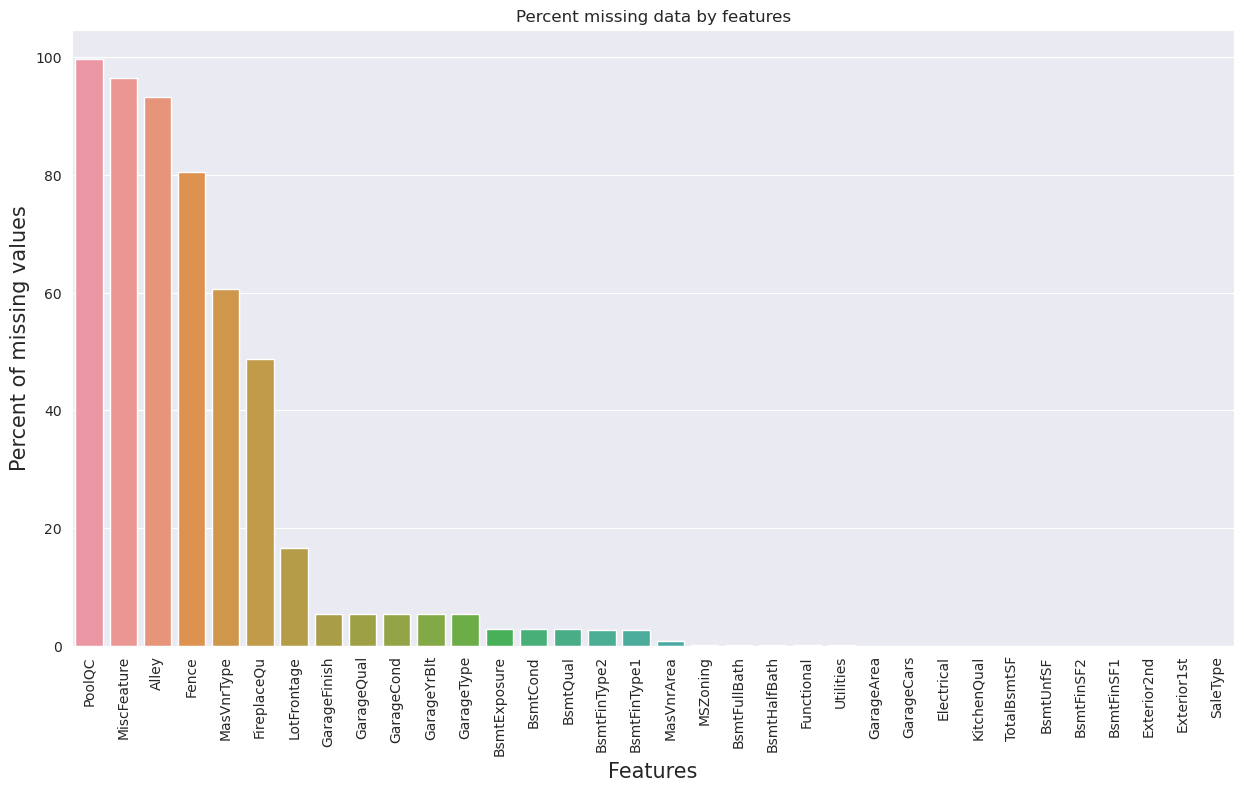

In [99]:
# 特征缺失率柱状图显示
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=missing_data.index, y=full_na)
plt.xticks(rotation='vertical')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by features')

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

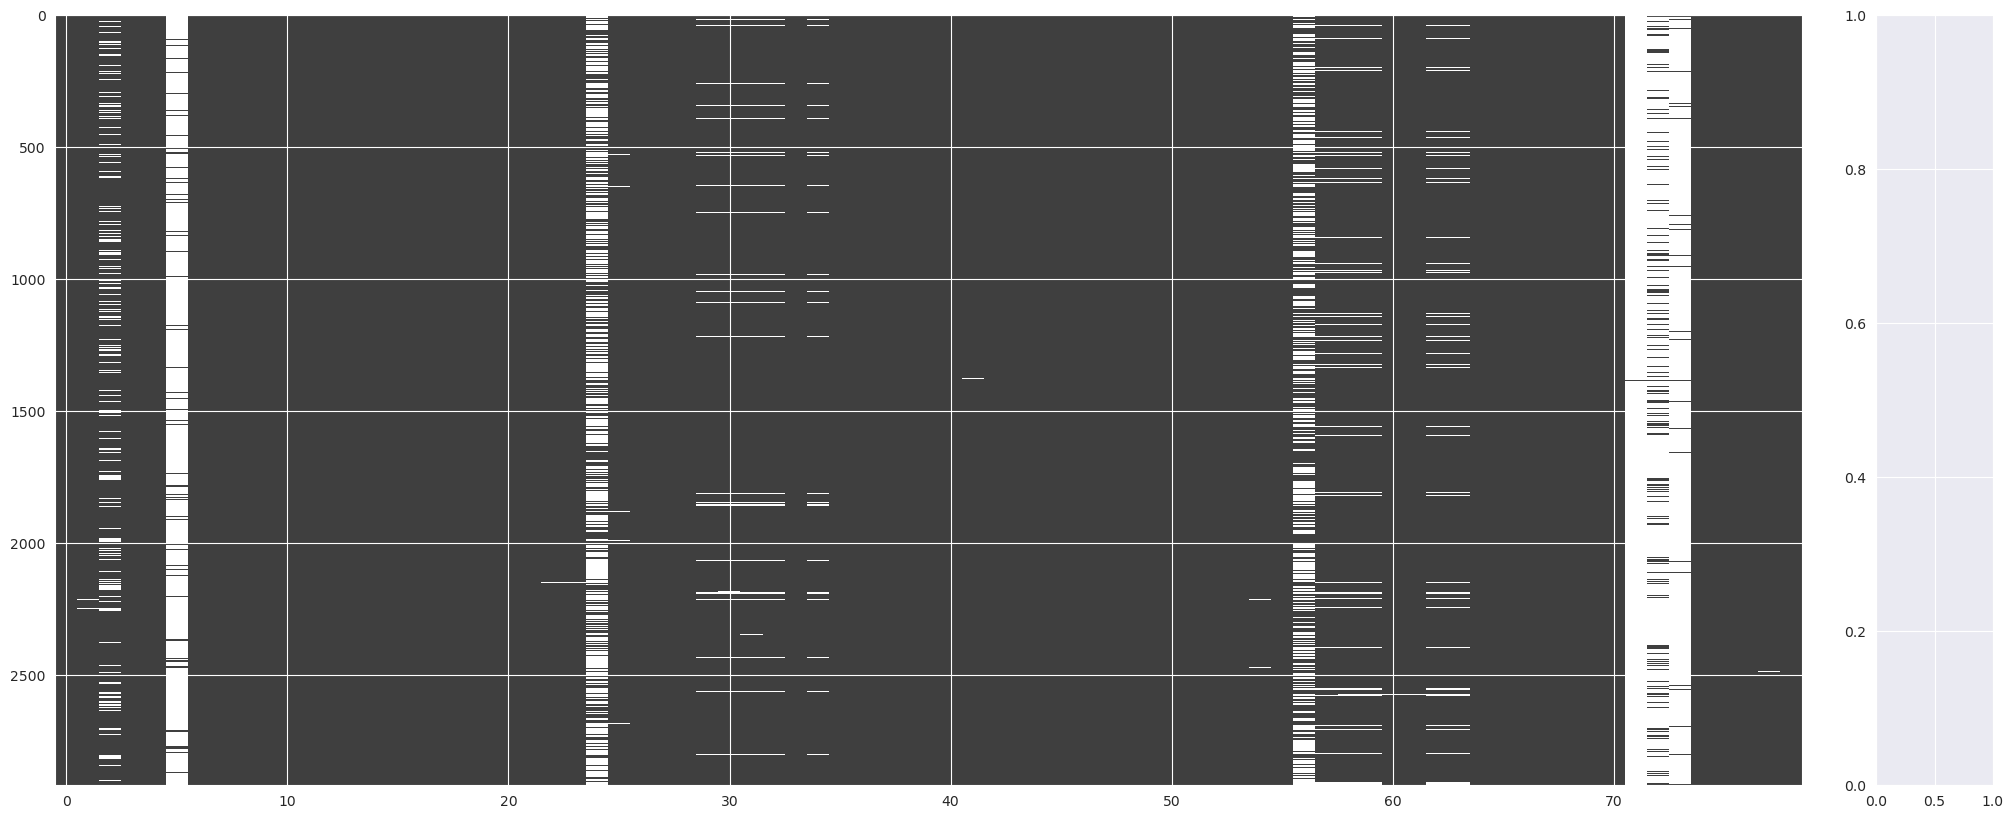

In [96]:
import missingno as msno

# 矩阵图查看缺失数据
msno.matrix(full)

<Axes: >

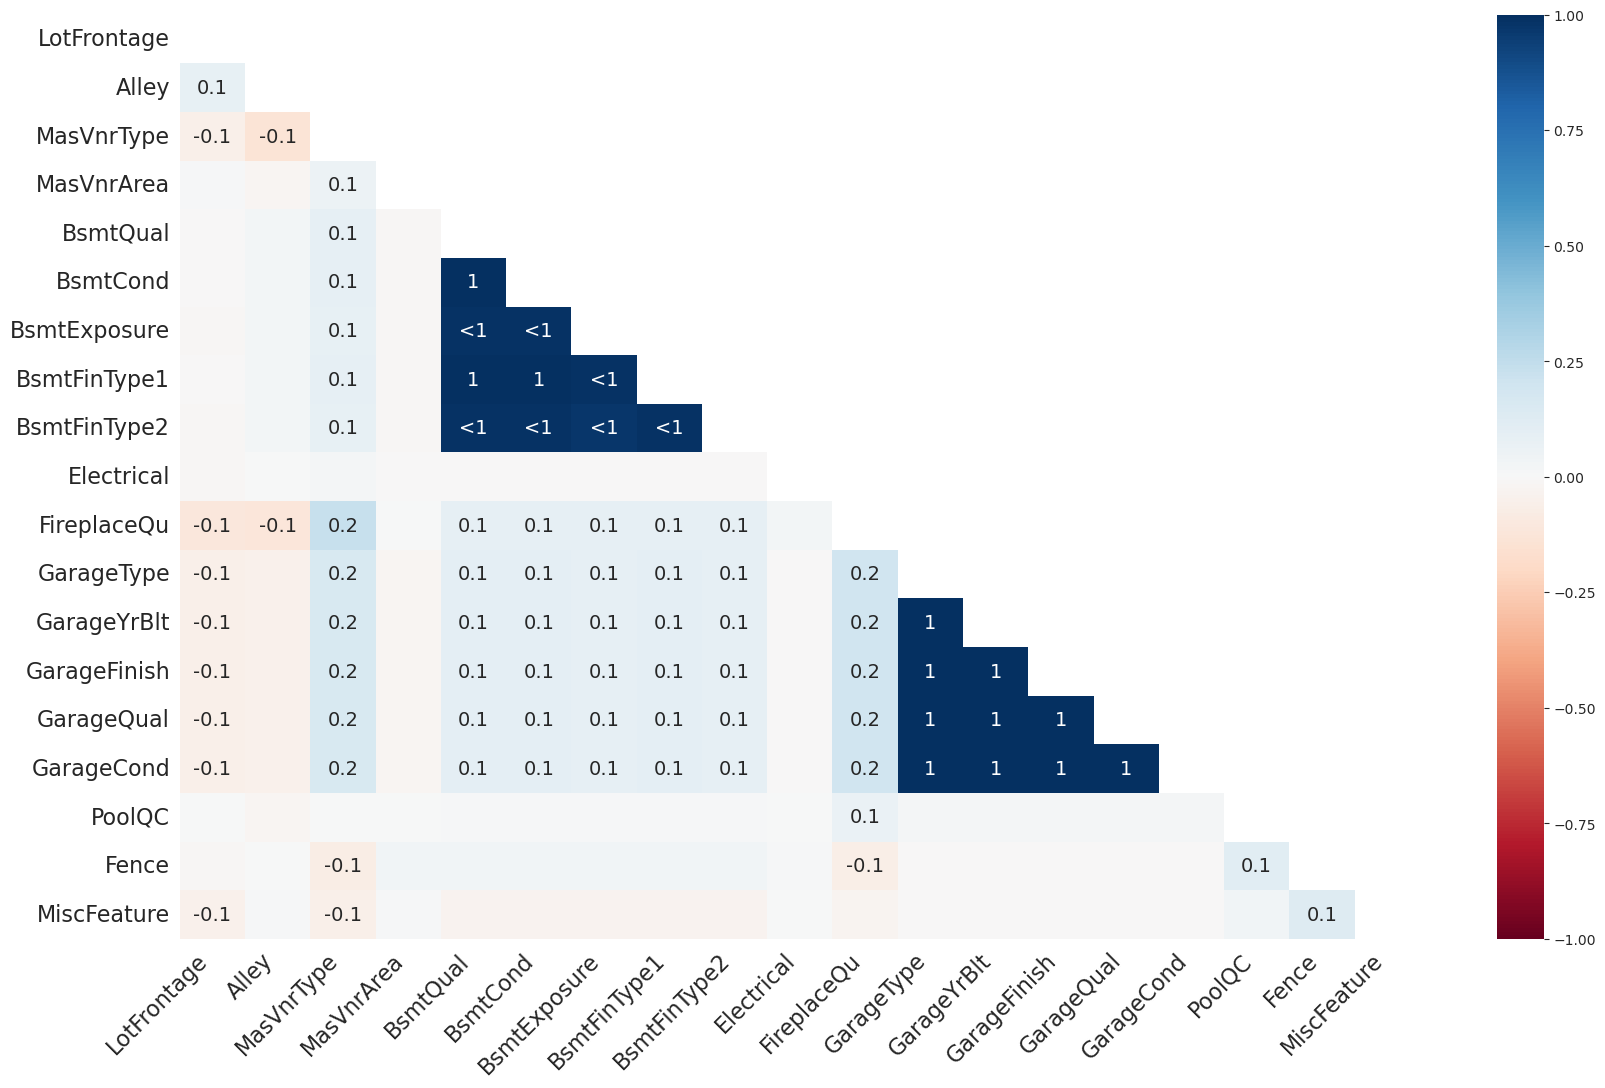

In [97]:
# 数据缺失值相关分析
msno.heatmap(data)

/data/anaconda3/envs/ML/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


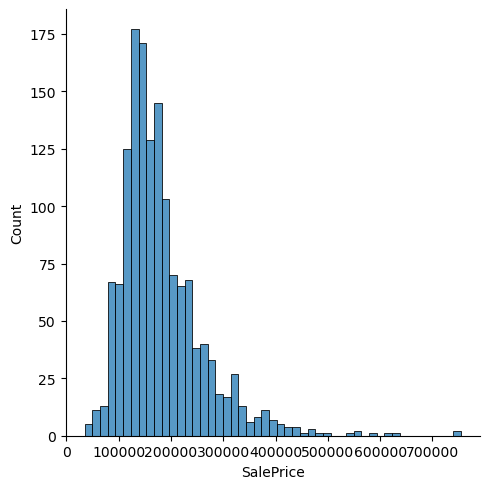